<a href="https://www.advfn.com/nasdaq/nasdaq.asp?companies=A">Nasdaq Stocks</a>

In [1]:
from datetime import datetime, timedelta
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
with open('../data/all_symbols.pkl', 'rb') as f:
    all_symbols = pickle.load(f)
    
len(all_symbols)

11032

In [3]:
def prepare_batches(all_symbols, batch_size=100):
    n = len(all_symbols)
    batches = []
    batch_start = 0
    batch_end = min(batch_start + batch_size, n)
    while batch_start < n:
        batches.append(all_symbols[batch_start:batch_end])
        batch_start = batch_end
        batch_end = min(batch_start + batch_size, n)
    return batches

In [4]:
batches = prepare_batches(all_symbols)

In [5]:
states = pd.read_csv('../data/hmm_exp_returns.csv')
states = states[['Date', 'state']]
states.index = pd.to_datetime(states.Date)
states.drop(columns='Date', inplace=True)
states.head()

,state
Date,
1970-01-02,0
1970-01-05,0
1970-01-06,0
1970-01-07,0
1970-01-08,0


In [6]:
states.state.value_counts()

3    3589
5    2221
1    1998
0    1781
4    1474
2    1289
6     998
Name: state, dtype: int64

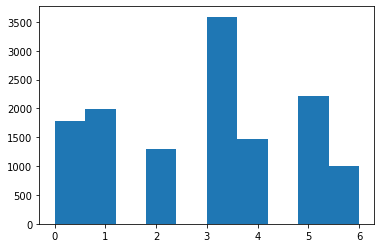

In [7]:
plt.hist(states.state);

In [8]:
STATES = sorted(states.state.unique())
STATES

[0, 1, 2, 3, 4, 5, 6]

In [9]:
CURRENT_STATE = states.state.to_numpy()[-1]
CURRENT_STATE

1

In [10]:
RUN = {
    0: 'all',
    1: 0,  # specific batch
    2: 'random_batch'
}[0]
MIN_OVERALL_SHARPE = 0.45
MIN_STOCK_PRICE = 1.00

In [11]:
if RUN == 'random_batch':
    n_batches = len(batches)
    idx = np.random.randint(0, n_batches)
    run_batches = [batches[idx]]
elif isinstance(RUN, int):
    run_batches = [batches[RUN]]
else:
    run_batches = batches
    
print('n batches:', len(run_batches))

n batches: 111


In [12]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 50
MIN_YEARS = 10
START = TODAY - timedelta(YEARS_OF_DATA * 365)
min_start = TODAY - timedelta(MIN_YEARS * 365)
if min_start.weekday() == 0:
    min_start -= timedelta(2)
elif min_start.weekday() == 6:
    min_start -= timedelta(1)
START, TODAY, min_start, min_start.weekday()

(datetime.date(1972, 12, 15),
 datetime.date(2022, 12, 3),
 datetime.date(2012, 12, 5),
 2)

In [13]:
START, TODAY

(datetime.date(1972, 12, 15), datetime.date(2022, 12, 3))

In [14]:
def download_data(symbols):
    std_out = sys.stdout
    null = open(os.devnull, 'w')
    sys.stdout = null
    try:
        data = (
            yf
            .download(symbols, start=START, end=TODAY)
            .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']
        data.index = pd.to_datetime(data.index)
        data = data.sort_index()
        data = data.loc[:, data.isnull().sum() != len(data)]
        missing_last = [
            col for col in list(data) if data[col].isnull()[-1]]
        data.drop(columns=missing_last, inplace=True)
        sys.stdout = std_out
        return data
    except BaseException as e:
        print(f'Failed to download data:\n{e}')

In [15]:
def adjust_min_date(min_date, dates):
    while pd.to_datetime(min_date) not in dates:
        min_date -= timedelta(1)
    return min_date

In [16]:
def filter_by_min_date(data, min_date):
    for col in data.columns:
        #if np.isnan(data.at[pd.to_datetime(min_date), col]):
        #    data.drop(columns=[col], inplace=True)
        if (
                data[col][data[col].notnull()].index[0] 
                > pd.to_datetime(min_date)):
            data.drop(columns=[col], inplace=True)
    return data

In [17]:
def filter_by_min_price(data):
    for col in data.columns:
        if (
                data[col][data[col].notnull()].to_numpy()[-1]
                < MIN_STOCK_PRICE):
            data.drop(columns=[col], inplace=True)
    return data

In [18]:
def get_daily_returns(x):
    idx = x.index
    n = len(x)
    x = np.array(x)
    returns = x[1:n] / x[0:(n-1)] - 1
    returns = pd.Series(returns, index=idx[1:])
    return returns

In [19]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [20]:
def get_sharpes_by_state(data):
    output = []
    stocks = [col for col in list(data) if col != 'state']
    for stock in stocks:
        stock_data = []
        returns = get_daily_returns(data[stock])
        sharpe = get_sharpe(returns)
        stock_data.append(sharpe)
        for state in STATES:
            sharpe_state = get_sharpe(returns[data.state == state])
            stock_data.append(sharpe_state)
        output.append(stock_data)
    df_out = pd.DataFrame(
        output,
        columns=['sharpe'] + [f'sharpe_{state}' for state in STATES],
        index=stocks)
    return df_out

In [21]:
def get_annualized_daily_return(returns):
    #s_returns = returns[data.state == 0]
    returns = np.array([1] + list((returns[returns.notnull()] + 1).to_numpy()))
    amt = returns.cumprod()
    n = len(returns)
    daily_return = amt[-1]**(1/max(n - 1, 1))
    return daily_return

In [22]:
def get_daily_annualized_return_by_state(data):
    output = []
    stocks = [col for col in list(data) if col != 'state']
    for stock in stocks:
        stock_data = []
        returns = get_daily_returns(data[stock])
        annualized_daily_return = get_annualized_daily_return(returns)
        stock_data.append(annualized_daily_return)
        for state in STATES:
            daily_annualized_return_state = get_annualized_daily_return(
                returns[data.state == state])
            stock_data.append(daily_annualized_return_state)
        output.append(stock_data)
    df_out = pd.DataFrame(
        output,
        columns=['dar'] + [f'dar_{state}' for state in STATES],
        index=stocks)
    return df_out

In [23]:
def best_n_by_state(df, n, state):
    candidates = df[df.sharpe >= MIN_OVERALL_SHARPE]
    return (
        candidates
        .sort_values(f'sharpe_{state}', ascending=False)
        .index[:n])

In [24]:
def process_batch(batch, min_start):
    data = download_data(batch)
    min_start = adjust_min_date(min_start, data.index)
    data = filter_by_min_date(data, min_start)
    data = filter_by_min_price(data)
    data = pd.concat([data, states], axis=1).loc[data.index, :]
    #state_sharpes = get_sharpes_by_state(data)
    #return state_sharpes
    state_dars = get_daily_annualized_return_by_state(data)
    return state_dars

In [25]:
dfs = []
print('Beginning batch:')
for batch in batches:
    print(batch[0], end=' ')
    df = process_batch(batch, min_start)
    dfs.append(df)

Beginning batch:
A ACER ADXS AHAC ALJJ AMOT APEN ARII ASVI AVCO BAH BDJ BIE BLTI BR BTI CACQ CBNK CDTX CGFW CIT CLWT CNVX CPLG CSBR CUBI CYPB DEA DLGC DRIO DXCM EE 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_28233/2514616766.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/max(n - 1, 1))


EMBC EPM ETR EZGO FE FIV FNVT FSLA FXJP GENI GLBC GOAM GSM HBCP HGLB HOG HTRN ICAB IGU INHO IPVI 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_28233/2514616766.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/max(n - 1, 1))


IVR JMSB KERX KRMD LCA LIN LPI LYV MCD MERX MIR MNTK MS MUE NAV NETI NM NRDS NURO 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_28233/2514616766.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/max(n - 1, 1))


NYXH OLLI ORCL PACX PCX PGHD PLL POWW PSAG PXMD RADI RENT RLTY RRI SAGA SCLN 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_28233/2514616766.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/max(n - 1, 1))


SFLY SILV SMMC SOLO SRCH STJ SWBD TBBK TFC TLEO TPPP TSHA TYDE UNFI VAC VINT VQS VYNE WGO WRE XENE YDKN ZOM 

In [26]:
df = pd.concat(dfs, axis=0)
df.head()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6
A,1.000303,0.995401,1.000914,1.000435,1.001297,1.001866,1.001851,1.015429
AA,1.000268,0.994129,1.000787,1.001124,1.001388,1.000924,1.001278,1.000767
AAIC,0.999502,0.992877,1.001101,1.000096,1.001596,1.000888,0.999976,1.019784
AAL,0.999939,0.993616,0.999549,1.002904,1.000671,1.000488,1.002071,1.024855
AAME,0.999982,0.996283,1.000082,1.001201,1.000889,1.000692,1.000040,1.001269


In [27]:
df.tail()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6
ZTEK,1.000612,0.998151,0.998618,0.999655,1.005320,1.002261,0.998727,1.038174
ZTR,1.000199,0.998321,1.000206,1.000277,1.000629,1.000693,1.000696,1.000631
ZUMZ,1.000141,0.995437,0.999913,1.001566,1.000587,1.000633,1.002063,1.007637
ZWS,1.000081,0.992960,1.001278,0.997106,1.001175,1.001927,1.001558,1.019815
ZYXI,1.000503,0.998122,1.001488,1.000981,1.000427,0.997927,1.003013,1.025934


In [28]:
df.to_csv('../data/sharpes_by_state.csv', index=True)

In [29]:
df = pd.read_csv('../data/sharpes_by_state.csv', index_col=0)

In [30]:
CURRENT_STATE# = 0

1

In [31]:
# Weighted Best
# 3: 0.2, 0.6, 0.2
# 2: 0.6, 0.4
#df['weighted'] = {
#    0: 0.6*df.sharpe_0 + 0.4*df.sharpe_1,
#    1: 0.2*df.sharpe_0 + 0.6*df.sharpe_1 + 0.2 * df.sharpe_2
#}[CURRENT_STATE]


if CURRENT_STATE == 0:
    df['weighted'] = (
        0.7*df[f'dar_{CURRENT_STATE}'] 
        + 0.1*df[f'dar_{CURRENT_STATE + 1}']
        + 0.2*df.dar)
elif CURRENT_STATE == 1:
    df['weighted'] = (
        0.6*df[f'dar_{CURRENT_STATE}']
        + 0.1*df[f'dar_{CURRENT_STATE + 1}']
        + 0.1*df[f'dar_{CURRENT_STATE - 1}']
        + 0.2*df.dar)
#elif CURRENT_STATE == ...
elif CURRENT_STATE == 7:
    df['weighted'] = (
        0.3*df[f'dar_{CURRENT_STATE}']
        + 0.5*df[f'dar_{CURRENT_STATE - 1}']
        + 0.2*df.dar)
df = df.sort_values('weighted', ascending=False)
df.head()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6,weighted
ELC,1.001289,0.997725,1.009156,0.996789,1.000562,1.002241,1.000480,0.987810,1.005203
GGE,1.000763,0.993610,1.006843,0.999041,1.002395,1.002139,0.999761,0.984568,1.003524
BRTX,0.995865,0.991479,1.007783,0.998926,0.992002,0.992924,0.993762,0.980940,1.002883
LFMD,1.000442,0.997849,1.004904,0.997689,1.002359,0.999817,0.998745,1.009025,1.002584
ENPH,1.001424,0.992256,1.005294,0.997557,1.000329,1.003804,1.003697,1.004632,1.002443


In [32]:
df.mean(), df.median()

(dar         1.000170
 dar_0       0.996376
 dar_1       1.000357
 dar_2       1.000680
 dar_3       1.001005
 dar_4       1.001120
 dar_5       1.000903
 dar_6       1.008673
 weighted    0.999953
 dtype: float64,
 dar         1.000269
 dar_0       0.996559
 dar_1       1.000431
 dar_2       1.000699
 dar_3       1.001026
 dar_4       1.001103
 dar_5       1.000912
 dar_6       1.006747
 weighted    1.000108
 dtype: float64)

In [44]:
always_exclude = ['NXN', 'NXP']
exclude = {
    0: ['ABST', 'AGI', 'APT', 'CZFS', 'ELC', 'ESOA', 'FSI', 'GCBC', 'GME', 'IPB', 'RNR', 'WTRG'],
    1: ['DTST', 'FSI'],
    7: ['ELC']}

In [45]:
best_weighted = [
    s for s in df.index if s not in exclude[CURRENT_STATE] + always_exclude
][:20]

In [46]:
print(sorted(best_weighted))

['AMRC', 'AMZN', 'BRTX', 'CHEF', 'COOP', 'CSIQ', 'CTSH', 'CVE', 'ELC', 'ENPH', 'GGE', 'GLDG', 'HBM', 'LFMD', 'NTAP', 'PACB', 'PAYS', 'RFP', 'TITN', 'TSLA']


In [47]:
df.loc[best_weighted]

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6,weighted
ELC,1.001289,0.997725,1.009156,0.996789,1.000562,1.002241,1.000480,0.987810,1.005203
GGE,1.000763,0.993610,1.006843,0.999041,1.002395,1.002139,0.999761,0.984568,1.003524
BRTX,0.995865,0.991479,1.007783,0.998926,0.992002,0.992924,0.993762,0.980940,1.002883
LFMD,1.000442,0.997849,1.004904,0.997689,1.002359,0.999817,0.998745,1.009025,1.002584
ENPH,1.001424,0.992256,1.005294,0.997557,1.000329,1.003804,1.003697,1.004632,1.002443
AMRC,1.000609,0.992860,1.004323,0.999659,1.001048,1.001902,1.001567,1.021149,1.001967
COOP,1.000496,0.995328,1.003967,0.999387,1.002085,1.001074,0.999386,1.022545,1.001951
PACB,0.999856,0.989272,1.005197,0.997861,1.000834,1.003244,0.999943,1.015909,1.001803
CVE,1.001468,0.995800,1.000801,1.013154,0.999478,1.000852,0.999909,1.024689,1.001670
RFP,1.000058,0.992165,1.003665,1.001889,0.999159,1.000280,1.001897,1.020573,1.001616


In [48]:
data = (
    yf
    .download(best_weighted, start=START, end=TODAY)
    .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']

[*********************100%***********************]  20 of 20 completed


In [49]:
data.index = pd.to_datetime(data.index)
data = data.sort_index()
data.tail()

,AMRC,AMZN,BRTX,CHEF,COOP,CSIQ,CTSH,CVE,ELC,ENPH,GGE,GLDG,HBM,LFMD,NTAP,PACB,PAYS,RFP,TITN,TSLA
Date,,,,,,,,,,,,,,,,,,,,
2022-11-28,61.660000,93.949997,2.6400,38.150002,44.180000,34.000000,60.099998,19.559999,0.550000,312.209991,3.28,1.25,5.34,2.38,72.570000,9.72,2.97,21.160000,35.450001,182.919998
2022-11-29,62.009998,92.419998,2.7850,38.270000,44.369999,33.820000,59.619999,20.370001,0.550000,303.390015,3.10,1.37,5.47,2.33,71.790001,9.45,2.97,21.160000,34.880001,180.830002
2022-11-30,65.519997,96.540001,3.0700,38.849998,45.160000,35.849998,62.209999,19.889999,0.580000,320.589996,2.91,1.37,5.65,2.43,67.610001,10.75,2.98,21.100000,44.029999,194.699997
2022-12-01,65.389999,95.500000,3.3400,39.139999,44.680000,34.650002,62.619999,19.650000,0.590000,314.000000,3.04,1.41,5.82,2.46,68.070000,11.08,2.96,21.090000,42.459999,194.699997
2022-12-02,67.639999,94.129997,3.6761,38.750000,44.580002,36.560001,62.389999,19.940001,22.469999,336.000000,3.07,1.55,5.85,2.61,66.430000,10.66,2.94,21.059999,42.450001,194.860001


In [50]:
data = pd.concat([data, states], axis=1)

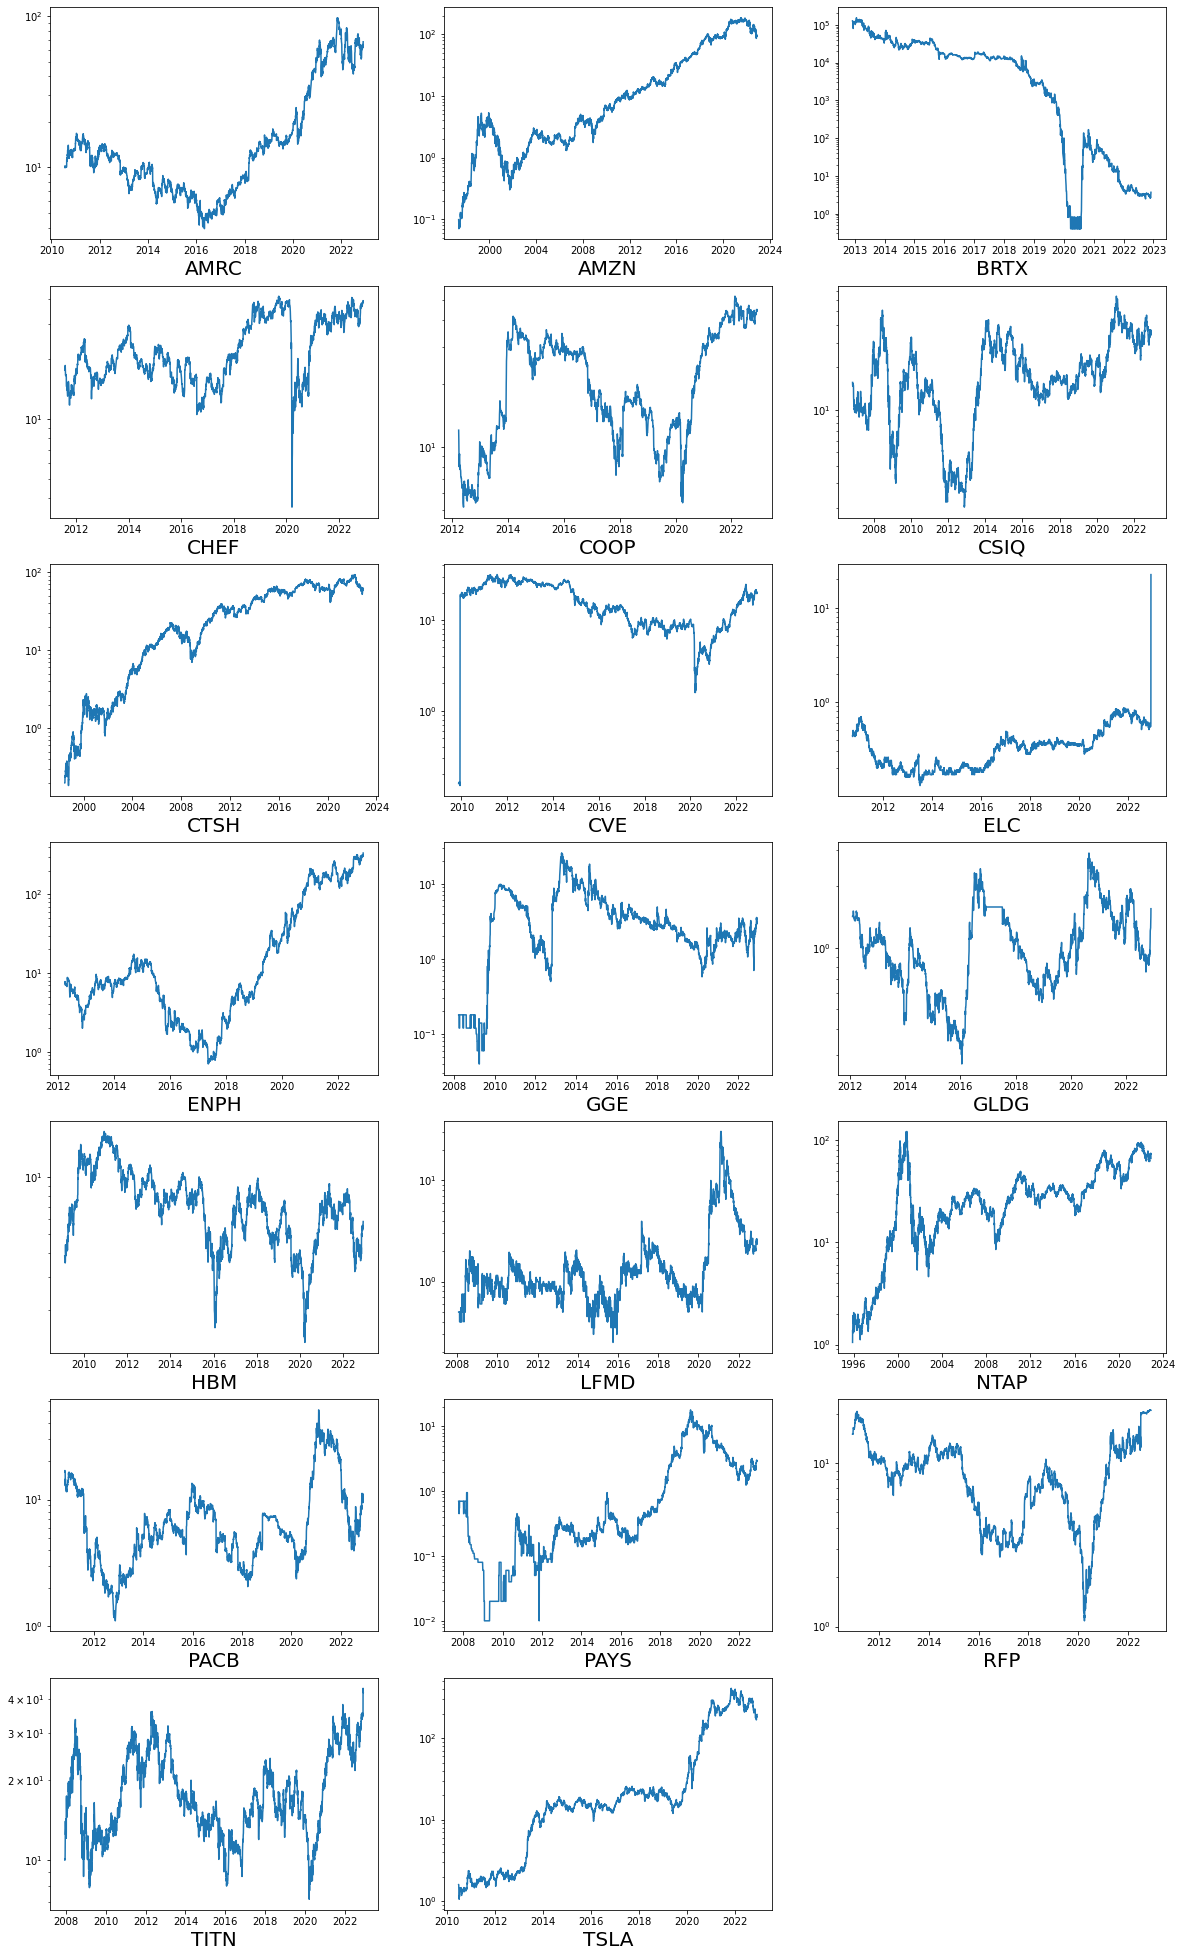

In [51]:
plt.rc('axes', labelsize=20)
plt.figure(figsize=[20, 35])
for i, sym in enumerate(list(data)):
    if sym == 'state':
        continue
    plt.subplot(7, 3, i + 1)
    plt.plot(data[sym])
    plt.xlabel(sym)
    plt.yscale('log');

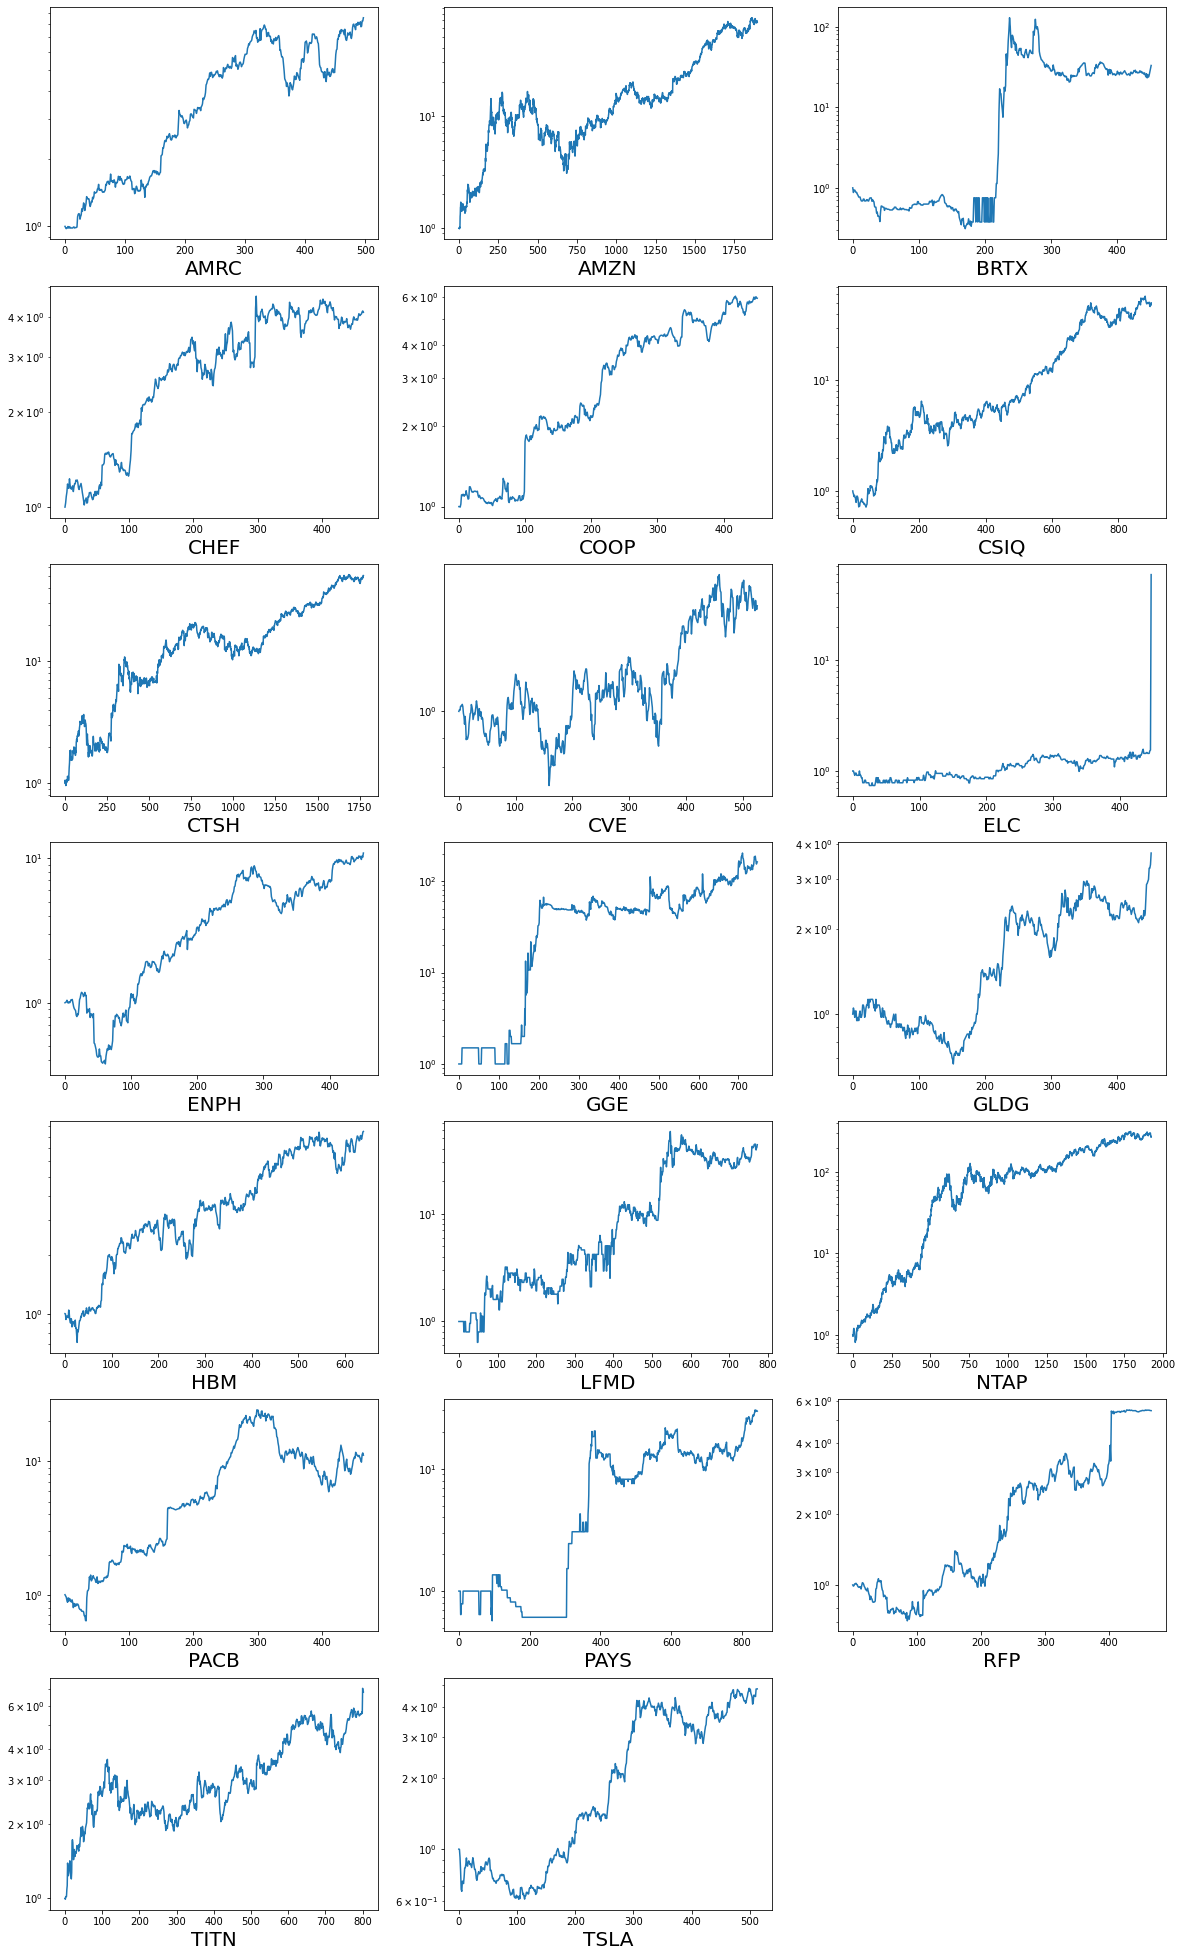

In [52]:
plt.figure(figsize=[20, 35])
for i, sym in enumerate(list(data)):
    if sym == 'state':
        continue
    plt.subplot(7, 3, i + 1)
    dr = get_daily_returns(data[sym])
    dr = dr[data.state == CURRENT_STATE]
    dr = dr[dr.notnull()]
    dr = (dr + 1).to_numpy()
    dr = np.array([1] + list(dr))
    plt.plot(dr.cumprod())
    plt.yscale('log')
    plt.xlabel(sym);